In [1]:
batch_size = 64
ncomps = 500
crop_size = 180

In [2]:

import os
import sys
import random
import numpy as np
import pandas as pd
import torch
from monai.data import DataLoader
from monai.transforms import Compose, NormalizeIntensity, ToTensor
import matplotlib.pyplot as plt
# import config_file as cfg
# from utils import get_model
# from torchsummary import summary

import torchvision.transforms.functional as F

/home/volatope/Software/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-06-19 14:04:17.800452: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 14:04:17.801552: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 14:04:17.826347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow w

In [3]:
from pathlib import Path

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')
exp_name = 'far_bias'

train_csv_path = macaw_path/'splits'/'train.csv'
train_img_path = macaw_path/exp_name/'train'

val_csv_path = macaw_path/'splits'/'val.csv'
val_img_path = macaw_path/exp_name/'val'

test_csv_path = macaw_path/'splits'/'test.csv'
test_img_path = macaw_path/exp_name/'test'
# 
pca_path = macaw_path/exp_name/f'train_hc_pca_{ncomps}.pkl'
# 
train_path = macaw_path/exp_name/f'train_hc_data_PCA_{ncomps}.pkl'
val_path = macaw_path/exp_name/f'val_hc_data_PCA_{ncomps}.pkl'
test_path = macaw_path/exp_name/f'test_hc_data_PCA_{ncomps}.pkl'

In [4]:
home_dir = './'
working_dir = home_dir + exp_name + '/'

df_train = pd.read_csv(train_csv_path)
df_val = pd.read_csv(val_csv_path)

train_fpaths = [os.path.join(working_dir, "train", filename) for filename in df_train['filename']]
train_class_label = df_train['class_label']

val_fpaths = [os.path.join(working_dir, "val", filename) for filename in df_val['filename']]
val_class_label = df_val['class_label']

In [5]:
df_train.head()

,Unnamed: 0,isv_dst,effect_dst,isv_bin,effect_bin,both_bins,bias_label,class_label,strat_col,filename
0,633,0.469869,2.469359,5,8,5_8,1,1,1_1_8_5,00000_0.47_S_2.469_D_1.289_B.tiff
1,394,0.736736,-1.525330,5,4,5_4,1,0,0_1_4_5,00001_0.737_S_-1.525_D_1.818_B.tiff
2,434,0.791011,-0.026890,5,3,5_3,1,1,1_1_3_5,00002_0.791_S_-0.027_D_1.422_B.tiff
3,685,-0.936475,-0.024416,3,3,3_3,1,1,1_1_3_3,00003_-0.936_S_-0.024_D_1.843_B.tiff
4,537,-0.209586,0.383522,4,4,4_4,1,1,1_1_4_4,00004_-0.21_S_0.384_D_3.023_B.tiff


In [6]:
df_val.head()

,Unnamed: 0,isv_dst,effect_dst,isv_bin,effect_bin,both_bins,bias_label,class_label,strat_col,filename
0,640,-0.341310,-1.538284,4,4,4_4,1,0,0_1_4_4,00000_-0.341_S_-1.538_D_2.29_B.tiff
1,117,-0.149281,0.142044,4,4,4_4,1,1,1_1_4_4,00001_-0.149_S_0.142_D_3.108_B.tiff
2,740,-0.555353,-2.209122,3,3,3_3,1,0,0_1_3_3,00002_-0.555_S_-2.209_D_1.999_B.tiff
3,183,0.724953,0.698132,5,5,5_5,1,1,1_1_5_5,00003_0.725_S_0.698_D_3.2_B.tiff
4,625,0.893030,0.959812,6,5,6_5,1,1,1_1_5_6,00004_0.893_S_0.96_D_4.045_B.tiff


In [7]:
if exp_name=='no_bias': 
    df_train['bias_label'].values[:]=0
    df_val['bias_label'].values[:]=0
    
print(df_train.bias_label.mean())
df_val.bias_label.mean()

0.5024875621890548


0.5020080321285141

In [8]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [9]:
seed = 1  # You can use any integer as the seed
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)

g = torch.Generator()
g.manual_seed(seed)

In [36]:
from utils.datasets import EmmaDataset
from monai.data import pad_list_data_collate
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB

# Define transforms
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])
# train_dataset = UKBBT1Dataset(train_csv_path, train_img_path, transforms.Compose([ToFloatUKBB(),ToTensor(), CenterCrop(crop_size)]))

# create a training data loader - include padding
# train_ds = ImageDataset(image_files=train_fpaths, labels=train_class_label, transform=transforms, reader="ITKReader")
train_ds = EmmaDataset(train_csv_path, train_img_path, exp_name=='no_bias',transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0,worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

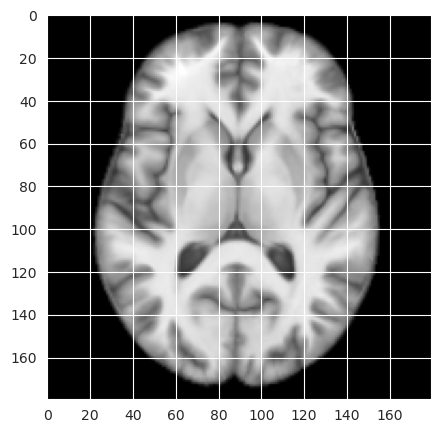

In [49]:
plt.imshow(next(iter(train_loader))[2][1], cmap='gray')

In [12]:
imgs = np.concatenate([d[2].numpy() for d in train_loader],axis=0)
imgs = imgs.reshape(imgs.shape[0],-1)
imgs_dim = imgs.shape[1]

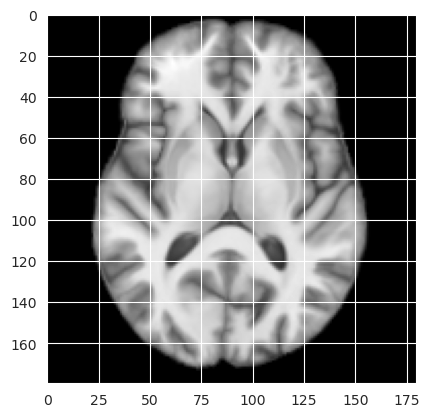

In [13]:
plt.imshow(imgs[0].reshape(crop_size,crop_size), cmap='gray')

## Dimensionality reduction

In [14]:
import pickle
from sklearn.decomposition import PCA

# if os.path.exists(pca_path):
#     with open(pca_path, 'rb') as f:
#         pca = pickle.load(f)
# else:
pca = PCA(n_components=ncomps)
pca.fit(imgs)

with open(pca_path, 'wb') as f:
    pickle.dump(pca, f)

In [15]:
# Initialize lists to collect data
imgs_list = []
disease_list = []
bias_list = []
train_img_names_list=[]

# Process each batch in the test_loader
for d in train_loader:
    disease_list.append(d[0].numpy())
    bias_list.append(d[1].numpy())
    imgs_list.append(d[2].numpy())
    train_img_names_list.append(d[3])

# Concatenate collected data after the loop
imgs = np.concatenate(imgs_list, axis=0)
imgs = imgs.reshape(imgs.shape[0], -1)
imgs_dim = imgs.shape[1]

train_img_names = np.concatenate(train_img_names_list, axis=0)

disease = np.concatenate(disease_list, axis=0)
bias = np.concatenate(bias_list, axis=0)

encoded_data = pca.transform(imgs)

In [16]:
with open(train_path, 'wb') as f:
    pickle.dump({'imgs':imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data, 'img_names':train_img_names}, f)

In [17]:
val_ds = EmmaDataset(val_csv_path, val_img_path, exp_name=='no_bias',transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=0,worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

In [18]:
# Initialize lists to collect data
imgs_list = []
disease_list = []
bias_list = []

# Process each batch in the test_loader
for d in train_loader:
    disease_list.append(d[0].numpy())
    bias_list.append(d[1].numpy())
    imgs_list.append(d[2].numpy())

# Concatenate collected data after the loop
imgs = np.concatenate(imgs_list, axis=0)
imgs = imgs.reshape(imgs.shape[0], -1)
imgs_dim = imgs.shape[1]

disease = np.concatenate(disease_list, axis=0)
bias = np.concatenate(bias_list, axis=0)
encoded_data = pca.transform(imgs)

In [19]:
with open(val_path, 'wb') as f:
    pickle.dump({'imgs':imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data}, f)

In [20]:
test_ds = EmmaDataset(test_csv_path, test_img_path, exp_name=='no_bias', transforms)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

In [22]:
test_ds.df.loc[test_ds.df['filename']=='00176_0.26_S_-0.941_D_1.539_B.tiff']

,Unnamed: 0,isv_dst,effect_dst,isv_bin,effect_bin,both_bins,bias_label,class_label,strat_col,filename
176,310,0.260473,-0.940866,5,5,5_5,1,0,0_1_5_5,00176_0.26_S_-0.941_D_1.539_B.tiff


In [23]:
# found = False
# 
# j=0
# 
# while not found:
#     d,b,img,names=next(iter(test_loader))
#     j+=1
#     
#     for i in range(len(d)):
#         # print(names[i])
#         if names[i] == '00176_0.26_S_-0.941_D_1.539_B.tiff':
#             found = True
#             print(d[i].item())
#             print(b[i].item())
#             print(i,j)

In [24]:
d,b,img,names = next(iter(test_loader))

In [25]:
test_ds.df.isna().sum()

Unnamed: 0     0
isv_dst        0
effect_dst     0
isv_bin        0
effect_bin     0
both_bins      0
bias_label     0
class_label    0
strat_col      0
filename       0
dtype: int64

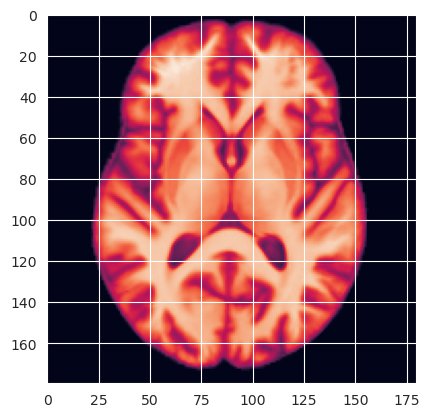

In [26]:
plt.imshow(next(iter(train_loader))[2][1])

In [27]:
test_imgs = np.concatenate([d[2].numpy() for d in test_loader],axis=0)
test_imgs = test_imgs.reshape(test_imgs.shape[0],-1)
test_imgs_dim = test_imgs.shape[1]

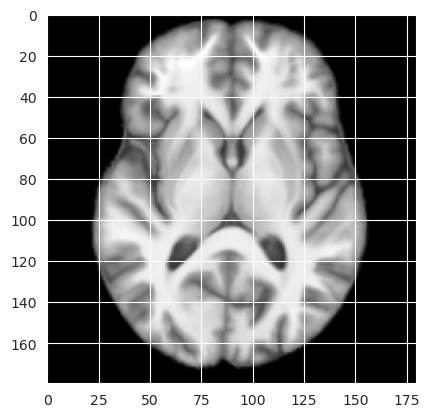

In [28]:
plt.imshow(test_imgs[1].reshape(crop_size,crop_size), cmap='gray')

In [29]:
sample_imgs = test_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

Disease: [1 1 0 1 1]
Bias: [1 0 0 0 1]


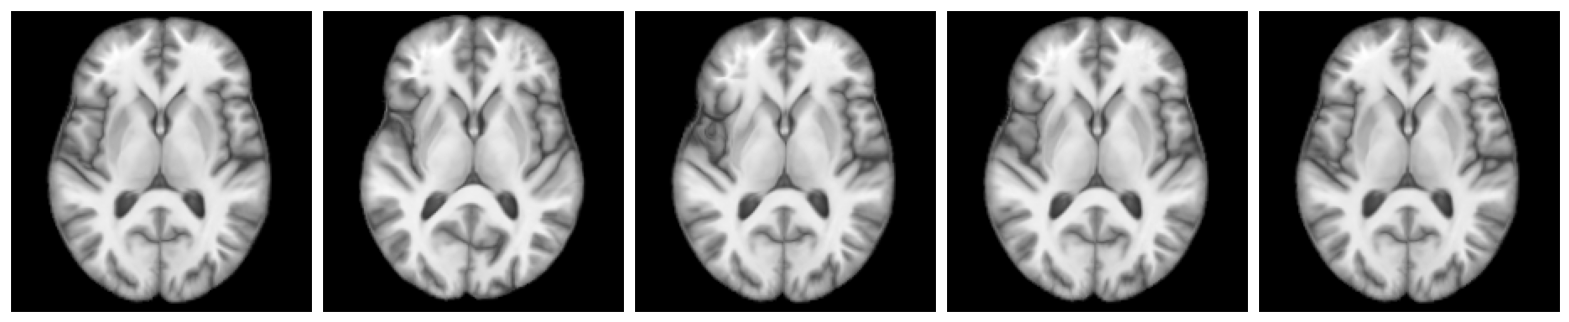

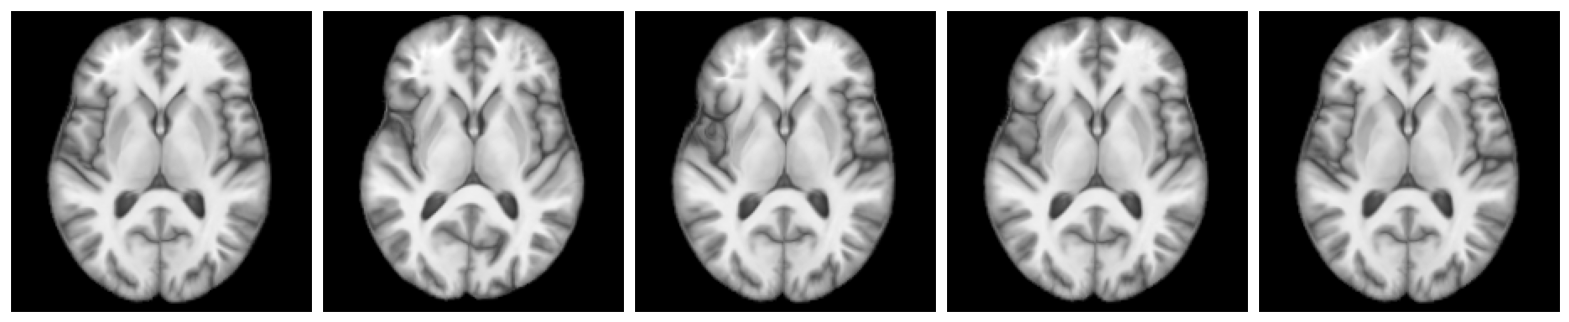

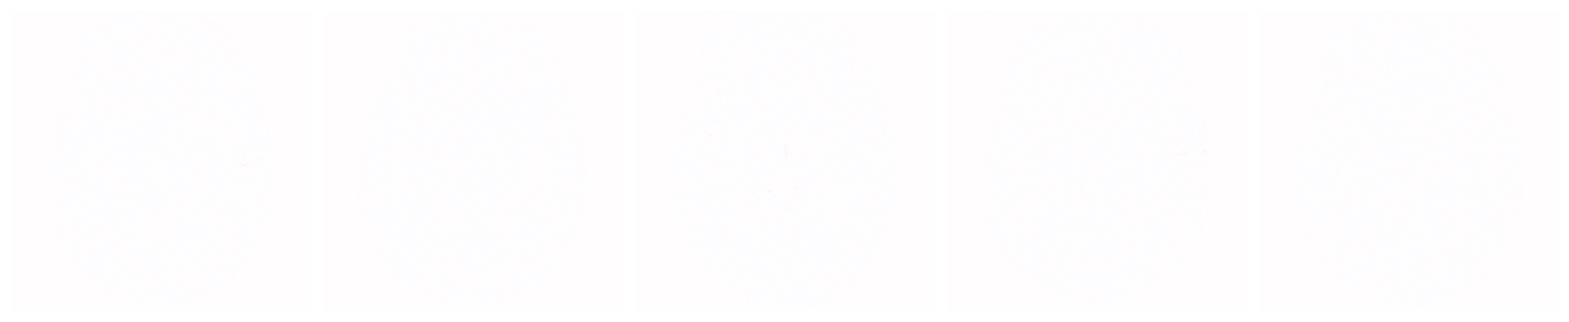

In [30]:
import utils.visualize as vis
print("Disease:", disease[:5])
print("Bias:",bias[:5])

plt.rcParams["figure.figsize"] = 20,5

diff = sample_imgs - X_recon
rr = X_recon + diff
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in sample_imgs], clim=(0,1), cols=5)
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in X_recon], clim=(0,1), cols=5)
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in diff],clim=(-.5,.5),cols=5, cmap='seismic')

In [31]:
max(diff[1])

0.0065134168

In [32]:
# Initialize lists to collect data
test_imgs_list = []
test_img_names_list = []
disease_list = []
bias_list = []

# Process each batch in the test_loader
for d in test_loader:
    disease_list.append(d[0].numpy())
    bias_list.append(d[1].numpy())
    test_imgs_list.append(d[2].numpy())
    test_img_names_list.append(d[3])
    
# Concatenate collected data after the loop
test_imgs = np.concatenate(test_imgs_list, axis=0)
test_imgs = test_imgs.reshape(test_imgs.shape[0], -1)
test_imgs_dim = test_imgs.shape[1]

test_img_names = np.concatenate(test_img_names_list, axis=0)

disease = np.concatenate(disease_list, axis=0)
bias = np.concatenate(bias_list, axis=0)

encoded_data = pca.transform(test_imgs)

In [33]:
np.max(X_recon)

1.0003358

In [34]:
with open(test_path, 'wb') as f:
    pickle.dump({'imgs':test_imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data, 'img_names':test_img_names}, f)